# FCA

Technical Challenge for Data Science Candidates

This workbook loads a pickle file from the loader notebook. It applies a number of models to the dataset.

## Conditional Processing

The notebook has to be used in a particular way. 

 1. One chooses a particular dataset
 2. One applies a particular model
 
## Datasets

 - Prescient Features

I use a *Prescient* dataset to check that the models will work. A *prescient* dataset is one that includes the outcome variable.

 - Naive Features

This removes the outcome variable and applies power models to the whole dataset with all features.

The performance of the different models with this dataset gives insights into the underlying data. Some datasets are more suited to tree models (non-parametric), some to parametric models. Random forest is an example of the former and logistic regression of the latter.

 - Refined Features
 
From the correlation results, it can be shown that fewer features can achieve comparable results.

## Methods

I will use a full cross-validation method and a train/test method. The cross-validation method will take the whole dataset and form a number of train/test datasets, but will train a model on the first set of training data and then apply it to the other sets.

This gives an insight into how much the model has over/under-fitted the data.

### Metrics

I've only used balanced_accuracy here. The default accuracy method can reach 90% if it spots all the true-negative results. This is mis-informative because the dataset contains just 10% true-positives.

Balanced-accuracy and recall are the most useful metrics for this dataset.

In [1]:
import numpy as np
import pandas as pd
import math
import json

from os import path

from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn import ensemble
from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

import scipy.stats as st
import statsmodels as sm
import statsmodels.api as smi
from sklearn import svm

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns

pd.__version__

'0.24.2'

In [2]:
# If you turn this feature on, you can display each result as it happens.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# this is the local Utility module and it reloaded each time.
from fca import Utility

In [4]:
%load_ext autoreload
%autoreload 1
%aimport fca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# My utility singleton.
i0 = Utility.instance()

## Dataset Filtering

There are some highly correlated features that might be confusing.
Build a naive model that uses all the features and refine it down.

Filter the dataset and then apply a selection of models.

In [6]:
# df2 = pd.read_pickle("coded.pickle")
df2 = pd.read_pickle("scaled.pickle")
df2.shape

(41188, 29)

In [7]:
# re-instate the boolean binary outcome
df2.y = df2.y > 0
df2.y;

In [8]:
## Low incidence rate may require some up-sampling.
np.sum(df2.y.values) / len(df2.y)

0.11265417111780131

### Reload the dataset for the model

You need to run this ode selectively to choose the right data-set for the model.

There is no scaling needed for the models chosen.
If you run all cells, the default is evaluate for the never-active with logistic regression.

### Splitting

I use sample0 for the different datasets. 
 1. use a train/test split
 2. use everything - let cross-validation make the splits
 
Initially, I only use sample0 at 2 and just look at the cross-validation results.

In [26]:
sample0=1

### Case 0: Prescient data

Null hypothesis.

I include the outcome variable - forcing over-fitting. All the models should converge to one. Or the data is structurally unsound (mis-scaled) or completely noise. I then remove each of the prescient variables.

In [27]:
y = df2.y
# X = df2.drop(columns=['y'])
X = df2

### Case 1: All features

Remove the outcome and get a baseline

In [28]:
y = df2.y
X = df2.drop(columns=['y'])
# X = df2
X.columns
X.shape

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'job0', 'marital0',
       'education0', 'default0', 'housing0', 'loan0', 'poutcome0', 'pdays0'],
      dtype='object')

(41188, 28)

### Case 2: case 1 and drop rows

This isn't used, but is worth investigating.

It filters the dataset into separate sets.

Example with dropping rows on a feature. This is scaled data. It may already be cut in an earlier notebook in which the scaling will be out.

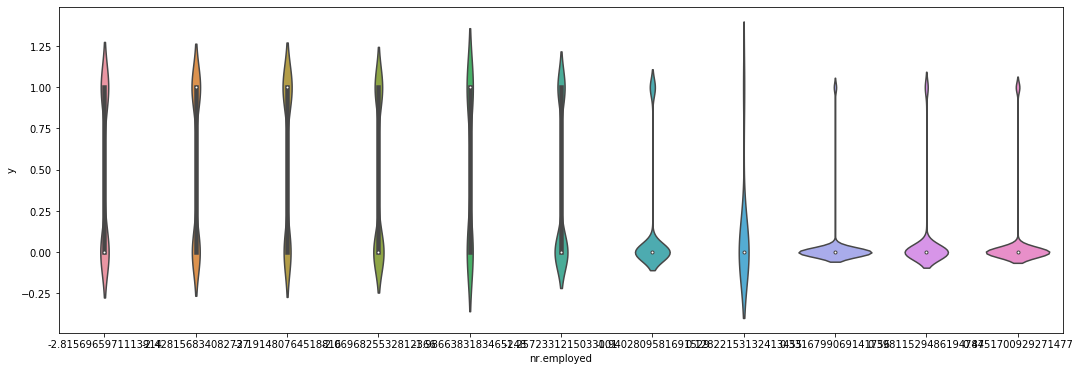

In [311]:
fig, ax = plt.subplots(figsize=(18,6))
sns.violinplot(ax=ax, x=X['nr.employed'], y=y)

In [482]:
y = df2.y
X = df2.drop(columns=['y'])
# X = df2
X.columns
X.shape

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'job0', 'marital0',
       'education0', 'default0', 'housing0', 'loan0', 'poutcome0', 'pdays0'],
      dtype='object')

(41188, 28)

In [312]:
# The decision tree  
# idxs = ~(X.pdays0 > -2.461)
idxs = X['nr.employed'] < -0.5
sum(idxs.values) / len(idxs.values)

0.3277168107215694

In [324]:
idxs = ~idxs

In [325]:
X = X[idxs]
y = y[idxs]

### Case 3: case 1 and drop columns

This removes a lot of the features and tries to get a comparable result to the full dataset.

It is useful to switch over to sample0 as 1 and to look at the confusion and performance matrices.

In [388]:
pcols = ['month', 'day_of_week', 'contact' ]
pcols = pcols + ['campaign']
pcols = pcols + ['marital0', 'education0', 'default0', 'housing0', 'loan0', 'pdays0']
pcols = pcols + ['job', 'education']

In [389]:
pcols = pcols + ['euribor3m', 'cons.price.idx' ]
pcols

['month',
 'day_of_week',
 'contact',
 'campaign',
 'marital0',
 'education0',
 'default0',
 'housing0',
 'loan0',
 'pdays0',
 'job',
 'education',
 'euribor3m',
 'cons.price.idx']

In [390]:
X = X.drop(columns=pcols)
X.columns

Index(['age', 'marital', 'default', 'housing', 'loan', 'duration', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.conf.idx', 'nr.employed',
       'job0', 'poutcome0'],
      dtype='object')

### Case 4: Just 5 features


In [29]:
p1 = ['age', 'job', 'marital', 'education', 'default']
p1 = ['age', 'nr.employed', 'poutcome0', 'pdays', 'default']
p1 = ['age', 'nr.employed', 'poutcome', 'pdays', 'duration']
X = X[p1]

X.columns

Index(['age', 'nr.employed', 'poutcome', 'pdays', 'duration'], dtype='object')

### Split the Data

In [30]:
Xcols = list(X.columns)
if sample0 == 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
elif sample0 == 2:
    X_train, X_test, y_train, y_test = ( X, None, y, None )

In [31]:
## Add some SMOTE
if False:
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    X_train = pd.DataFrame(data=X_train, columns=Xcols)

In [32]:
X_train.shape
y_train.shape
Xcols

(32950, 5)

(32950,)

['age', 'nr.employed', 'poutcome', 'pdays', 'duration']

## Model cases

Again choose one to apply to the data you've chosen.

These are a number of models that can be applied. Some are 'patchy', results have high variance. Some are good for spotting mal-formed features.

    1. The first SVC is not practical for "big" data (width and count), but works well for smaller ones.
    
    2. The Decision Tree Classifier is a single-tree based on information gain. It can be thought of as a single iteration of Random Forest.

    3. The Multi-Layer Perceptron Classifier is a useful neural network and can get reasonable results quickly - it parallizes well. The hidden_layer_sizes need tuning to get a cross validation score over 0.5. Can be patchy. Spots prescients. It is can be thought of as a set of interlocking trees.

    4. Gradient-boosted can be fast and spots prescients. Structurally, it can be thought of as a patchwork quilt of decision trees.
    
    5. Random-forest usually gets balanced results. It aggregates across trees. It is less prone to over-fitting.

    6. The logistic regression classifier is a parametric method and only uses Maximum-Likelihood Estimation but across all the features. It is prone to under-fitting. Usually spots prescients.
    
When the MLPC is patchy, it usually means there is a useful split to be made. There is a Decision Tree Classifier below that can help find the split.

In [24]:
clf = svm.SVC(kernel='linear', C=1)

In [509]:
# Useful method. Reduce the size of the neural network to find a path with prescient features. log_2 should be minimal
x0 = math.floor(math.log(X.shape[1], 2))
clf =  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(x0, x0, 2), 
                     random_state=1, warm_start=True)

In [366]:
# Very accurate
p0 = {'n_estimators': 1000, 'max_leaf_nodes': 8, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 8}
# Less so
p0 = {'n_estimators': 1000, 'max_leaf_nodes': 8, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 8}
params = p0

clf = ensemble.GradientBoostingClassifier(**params)

In [510]:
# Not accurate
p0 = { 'max_depth':2, 'random_state': 0, 'n_jobs': 4, 'warm_start': False }
# Very accurate
p0 = { 'n_estimators': 1000, 'max_depth':8, 'random_state': 2, 'n_jobs': 4, 'warm_start': True, 
      'bootstrap': True, 'max_features': None }

params = p0

clf = ensemble.RandomForestClassifier(**params)

In [33]:
clf = LogisticRegression(C=1e4, solver='lbfgs', multi_class='auto', max_iter=10000) # max_iter is 2 orders up!

In [362]:
# Useful for plotting see below
# This can be compared with the MLCP if we have patchy validation results.
clf = tree.DecisionTreeClassifier()

## From cross-validation results, compare models for fitting issues

To evaluate the model under a cross-validation scheme, run this cell.

The scoring metric is a balanced accuracy one. Cross-validation applies a model trained on one training to a number of others. Variable accuracy results indicate over-fitting; very similar results would suggest under-fitting.

Under-fitting usually arises when there are not enough features. Over-fitting when there are too many samples.

In [34]:
scores = cross_val_score(clf, X_train, y_train, cv=5, error_score=np.nan, scoring='balanced_accuracy')
scores
X_train.columns

array([0.68502509, 0.68812325, 0.67852619, 0.67572337, 0.68805073])

Index(['age', 'nr.employed', 'poutcome', 'pdays', 'duration'], dtype='object')

## Confusion Matrix

If sample0 is 1 look at the confusion and performance matrices

In [21]:
def perf0(X, y):
    global clf
    y_pred = clf.predict(X)
    return (metrics.accuracy_score(y, y_pred), metrics.balanced_accuracy_score(y, y_pred), metrics.confusion_matrix(y, y_pred))

In [35]:
clf = clf.fit(X_train, y_train)

perf0(X_train, y_train)

(0.9092564491654022, 0.6832926950925087, array([[28499,   715],
        [ 2275,  1461]]))

In [36]:
a0, a1, conf0 = perf0(X_test, y_test)
conf0
tn, fp, fn, tp = conf0.ravel()
(tn, fp, fn, tp)

array([[7133,  201],
       [ 577,  327]])

(7133, 201, 577, 327)

In [37]:
print(metrics.classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.93      0.97      0.95      7334
        True       0.62      0.36      0.46       904

    accuracy                           0.91      8238
   macro avg       0.77      0.67      0.70      8238
weighted avg       0.89      0.91      0.89      8238



#### Collate Probabilities

I haven't joined the results back to the original data.

In [271]:
y_p = clf.predict_proba(X_train)

R = X_train.copy(deep=True)
R['y'] = y
R['Py'] = y_p[:, 0]
R = R.sort_values(by='Py', ascending=False)
R.head()

,age,nr.employed,poutcome0,pdays,duration,y,Py
40997,-1.441693,-2.815697,0.397706,0.194144,-0.969179,False,0.999953
40841,-0.769980,-2.815697,0.397706,0.194144,-0.973036,False,0.999953
40846,-1.729570,-2.815697,0.397706,0.194144,-0.946038,False,0.999953
40705,-0.865939,-2.815697,0.397706,0.194144,-0.976893,False,0.999953
40939,-1.249775,-2.815697,0.397706,0.194144,-0.976893,False,0.999953


## Feature selection

Try to determine best features. It is not usually sufficient to choose the top-ranked features. It is best to be selective and choose the best feature for a particular group of features. The best feature is not the most defined or the most correlated with respect to the outocome feature; it may be the one that preserves the distribution best.

In [38]:
clf # remind ourselves which classifier we're using.

LogisticRegression(C=10000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
# create the RFE model and select 3 attributes
rfe = RFE(clf, 5)
rfe = rfe.fit(X_train, y_train); # suppress messages Future Warning
# summarize the selection of the attributes
rfe.support_
rfe.ranking_

array([ True,  True,  True,  True,  True])

array([1, 1, 1, 1, 1])

In [40]:
x0 = np.array(Xcols)
f0s = list(x0[rfe.support_]) # just the first choices
f0s

['age', 'nr.employed', 'poutcome', 'pdays', 'duration']

In [41]:
# And in order
rnk0 = pd.DataFrame(data={'name': list(X_train.columns), 'rank': rfe.ranking_})
rnk0 = rnk0.sort_values(['rank'])
rnk0.reset_index(drop=True)

,name,rank
0,age,1
1,nr.employed,1
2,poutcome,1
3,pdays,1
4,duration,1


In [212]:
# Get the top five and plug them into the selection case 4.

list(rnk0[:5]['name'].values)

['age', 'nr.employed', 'euribor3m', 'pdays', 'duration']

### Decision Tree Classifier

This is hard work for scikit-learn

In [ ]:
# Train Decision Tree Classifer

cols = X_train.columns
cols = list(set(cols).difference(f0s))
cols

clf = clf.fit(X_train[cols], y_train)
y_pred = clf.predict(X_train[cols])
metrics.accuracy_score(y_train, y_pred)

In [ ]:
tree.plot_tree(clf, max_depth=4, feature_names = cols, class_names=['0','1'])

In [ ]:
dot_data = 'tree.dot'
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, max_depth=4, feature_names = cols, class_names=['0','1'])

# Summary

